In [1]:
using PyPlot, FileIO, JLD2
using StochasticRounding, SoftPosit, LogFixPoint16s
using StatsBase, LinearAlgebra, Statistics
LogFixPoint16s.set_nfrac(10)   # use the 16-bit logfix format similar to Float16

┌ Warning: LogFixPoint16 was changed to 5 integer and 10 fraction bits.
└ @ LogFixPoint16s /Users/milan/.julia/packages/LogFixPoint16s/TGYbV/src/change_format.jl:25


In [46]:
function planar_map(x::T,
                    y::T;
                    a::Real=0.9,
                    b::Real=1.0,
                    c::Real=0.9,
                    d::Real=0.0,
                    N::Int=100) where T

    a,b,c,d = T.((a,b,c,d))        # convert a,b,c to format T
    p = T(Float64(π))              # π of type T
    
    xout = Array{T,1}(undef,N+1)   # preallocate
    yout = Array{T,1}(undef,N+1)
    xout[1] = x                    # store initial condition
    yout[1] = y
    
    for i in 2:N+1
        x1 = sin(x*(a*p*cos(p*y) + b))
        y1 = c*(sin(p*y+d) - sin(d)) + sin(p*x)
        
        xout[i] = x1               # store iteration
        yout[i] = y1
        x,y = x1,y1                # swap next step with prev step
    end
    return xout,yout
end

planar_map (generic function with 1 method)

## 1. Visualise the attractor

In [117]:
function attractor(::Type{T}=Float64;
                    N::Int=10000,
                    Nspinup::Int=100,
                    b::Real=1.0,
                    Nens::Int=1000) where T
    
    # preallocate
    X = fill(0.0,Nens,N)
    Y = fill(0.0,Nens,N)

    # run ensemble and discard spin up in format T
    for iens in 1:Nens
        x,y = planar_map(T.(2*rand(2) .- 1)...,N=N+Nspinup;b)
        X[iens,:],Y[iens,:] = x[Nspinup+2:end],y[Nspinup+2:end]
    end
    
    return X,Y
end

attractor (generic function with 2 methods)

In [118]:
X,Y = attractor(Float64);

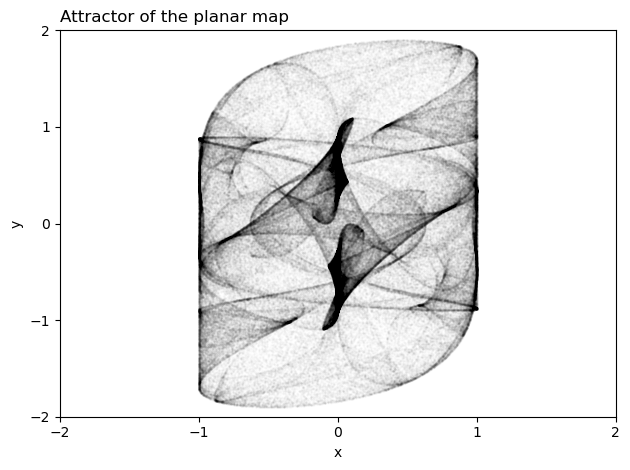

In [106]:
fig,ax = subplots(1,1)

ax.scatter(X,Y,1,color="k",alpha=0.01)

ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xticks(-2:2)
ax.set_yticks(-2:2)
ax.set_title("Attractor of the planar map",loc="left")
tight_layout()

## 2. Attractor by number format

In [137]:
bs = [0.8,1.0,1.2]
formats = [Float64,Float32,Float16,Posit32,Posit16,Float32sr,Float16sr]

Nbs = length(bs)
Nformats = length(formats)

Nens = 500
X,Y = attractor(Float64;Nens);

Xb = fill(0f0,Nformats,Nbs,length(X))
Yb = fill(0f0,Nformats,Nbs,length(Y))

for (ibs,b) in enumerate(bs)
    for (iformat,format) in enumerate(formats)
        X,Y = attractor(format;b,Nens)
        Xb[iformat,ibs,:] = vec(X)
        Yb[iformat,ibs,:] = vec(Y)
    end
end

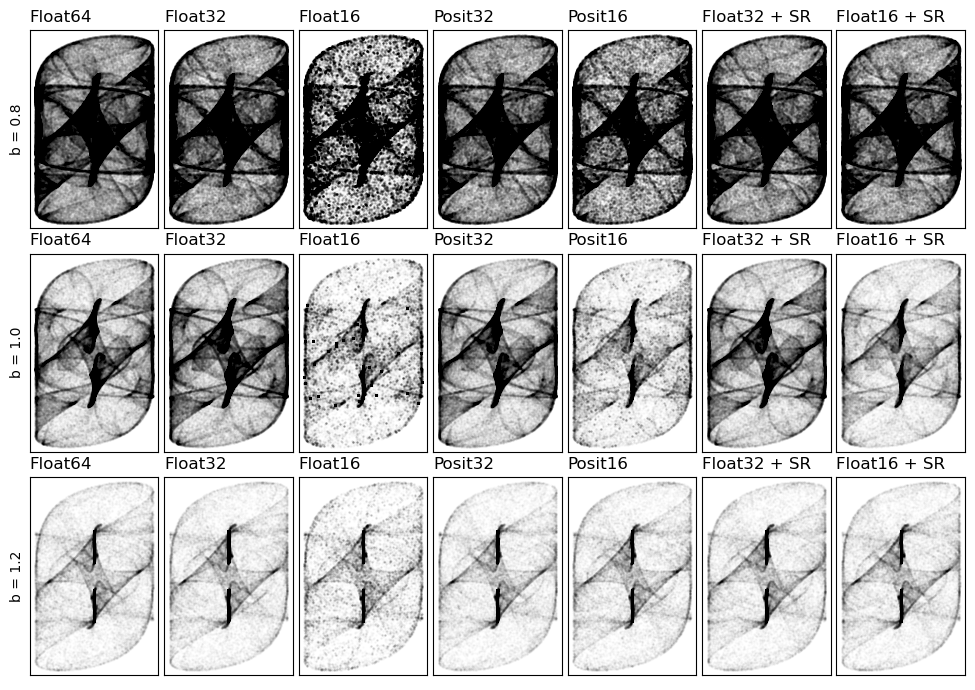

In [146]:
fig,axs = subplots(Nbs,Nformats,sharex=true,sharey=true,figsize=(10,7))

for (ibs,b) in enumerate(bs)
    for (iformat,format) in enumerate(formats)
        
        if ibs == 1 # subsample for b < 1 to avoid overcrowded attractor
            r = rand(1:length(X),500000)
            X,Y = Xb[iformat,ibs,r],Yb[iformat,ibs,r]
        else
            X,Y = Xb[iformat,ibs,:],Yb[iformat,ibs,:]
        end
        
        axs[ibs,iformat].scatter(X,Y,1,color="k",alpha=0.01)
        
        if format == Float32sr
            axs[ibs,iformat].set_title("Float32 + SR",loc="left")
        elseif format == Float16sr
            axs[ibs,iformat].set_title("Float16 + SR",loc="left")
        else
            axs[ibs,iformat].set_title("$format",loc="left")
        end
    end
end

for (ib,b) in enumerate(bs)
    axs[ib,1].set_ylabel("b = $b")
end

axs[1,1].set_xlim(-1.1,1.1)
axs[1,1].set_ylim(-2,2)
axs[1,1].set_yticks([])
axs[1,1].set_xticks([])
tight_layout(w_pad=-1,h_pad=0)
savefig("../plots/planarmap_attractor.png")

## WIP

In [ ]:
# bs = collect(0.8:1e-3:1.3)
# formats = [Float64,Float32,Float16,Posit32,Posit16,Float32sr,Float16sr]

# Nbs = length(bs)
# Nformats = length(formats)
# N = 500
# Nspinup = 100
# Nens = 100

# Xb = fill(0.0,Nformats,Nbs,Nens*N)
# Yb = fill(0.0,Nformats,Nbs,Nens*N)

# bb = fill(0.0,Nbs,Nens*N)
# for (ib,b) in enumerate(bs)
#     bb[ib,:] .= b
# end

# for (iformat,format) in enumerate(formats)
#     for (ib,b) in enumerate(bs)
        
#         X = fill(0.0,Nens,N)
#         Y = fill(0.0,Nens,N)

#         for iens in 1:Nens
#             x,y = planar_map(format.(2*rand(2) .- 1)...,N=N+Nspinup;b)
#             X[iens,:],Y[iens,:] = x[Nspinup+2:end],y[Nspinup+2:end]
#         end
        
#         Xb[iformat,ib,:] = vec(X)
#         Yb[iformat,ib,:] = vec(Y)
#     end
# end